In [1]:
!pip install torch==1.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 735.5 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.8.0 which is incompatible.


In [2]:
!pip install torchvision==0.9.0 --quiet

     |████████████████████████████████| 17.3 MB 6.9 MB/s 


In [3]:
!pip install torchtext==0.9.0 --quiet

     |████████████████████████████████| 7.1 MB 8.1 MB/s 


In [26]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


In [5]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd


Mounted at /content/drive


In [6]:
raw_df = pd.read_csv('/content/drive/MyDrive/data/bert/BBC News Train.csv')

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.6 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.2 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [9]:
import pickle
import time
import string
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns


In [27]:
import torch
from torchtext.legacy import data
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
RANDOM_STATE = 1

In [12]:
MAX_SEQ_LEN = 200

def preprocess_text(text):
  text = text.split()
  text = ' '.join(text[:MAX_SEQ_LEN])
  text = text.lower()
  return text

In [16]:
raw_df['Text1'] = raw_df['Text'].apply(lambda x: preprocess_text(x))


In [14]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()


In [17]:
raw_df['Category_encoded'] = oe.fit_transform(raw_df[['Category']]).astype(int)


In [18]:
raw_df

,ArticleId,Text,Category,Text1,Category_encoded
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,4
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in $168m payout eighteen former e...,0
...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction from big brother model caprice...,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart show dj duo jk and ...,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hits reuters revenues at media gro...,0
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple has exp...,4


In [19]:
labels = raw_df['Category'].unique().tolist()

In [21]:
 df = raw_df[['Category_encoded','Text1']]
 df.columns = ['label', 'titlebody'] 

In [22]:
df_business = df[df['label'] == 0]
df_entertainment = df[df['label'] == 1]
df_politics = df[df['label'] == 2]
df_sport = df[df['label'] == 3]
df_tech = df[df['label'] == 4]

# Train-valid-test split 8:1:1

df_business_train, df_business_rem = train_test_split(df_business, train_size=0.8, random_state=RANDOM_STATE)
df_entertainment_train, df_entertainment_rem = train_test_split(df_entertainment, train_size=0.8, random_state=RANDOM_STATE)
df_politics_train, df_politics_rem = train_test_split(df_politics, train_size=0.8, random_state=RANDOM_STATE)
df_sport_train, df_sport_rem = train_test_split(df_sport, train_size=0.8, random_state=RANDOM_STATE)
df_tech_train, df_tech_rem = train_test_split(df_tech, train_size=0.8, random_state=RANDOM_STATE)

df_business_valid, df_business_test = train_test_split(df_business_rem, train_size=0.5, random_state=RANDOM_STATE)
df_entertainment_valid, df_entertainment_test = train_test_split(df_entertainment_rem, train_size=0.5, random_state=RANDOM_STATE)
df_politics_valid, df_politics_test = train_test_split(df_politics_rem, train_size=0.5, random_state=RANDOM_STATE)
df_sport_valid, df_sport_test = train_test_split(df_sport_rem, train_size=0.5, random_state=RANDOM_STATE)
df_tech_valid, df_tech_test = train_test_split(df_tech_rem, train_size=0.5, random_state=RANDOM_STATE)


df_train = pd.concat([df_business_train, df_entertainment_train, df_politics_train, df_sport_train, df_tech_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_business_valid, df_entertainment_valid, df_politics_valid, df_sport_valid, df_tech_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_business_test, df_entertainment_test, df_politics_test, df_sport_test, df_tech_test], ignore_index=True, sort=False)

In [23]:
# Save to file
df_train.to_csv('./train.csv', index=False)
df_valid.to_csv('./valid.csv', index=False)
df_test.to_csv('./test.csv', index=False)

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameters
BATCH_SIZE = 16
MAX_SEQ_LEN = 200
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [28]:

# Fields
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = data.Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('titlebody', text_field)]

In [31]:
PATH = '.'

In [32]:
# TabularDataset
train, valid, test = data.TabularDataset.splits(path=PATH, train='train.csv', validation='valid.csv', test='test.csv', format='CSV', fields=fields, skip_header=True)

In [33]:
# Iterators
train_iter = data.BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = data.BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
test_iter = data.Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [34]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel, self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        return loss, text_fea

In [35]:
def save_model(path, model, valid_loss):
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, path)

def load_model(path, model):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)

def load_metrics(path):
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [36]:
def train(model, optimizer, train_set=train_iter, valid_set=valid_iter,
          num_epochs=5, eval_every = len(train_iter) // 2,
          file_path = PATH, best_valid_loss = float("Inf")):
    
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    inference_time = 0.0
    inference_count = 0

    # Training loop
    model.train()
    for epoch in tqdm(range(num_epochs)):
      # Perform one full pass over the train set
      print('======= Epoch [{}/{}] ======='.format(epoch+1, num_epochs))

      for (labels, titlebody), _ in tqdm(train_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        start_time = time.time()
        loss, _ = model(titlebody, labels)
        torch.cuda.synchronize()
        time_taken = time.time() - start_time
        inference_time += time_taken
        inference_count += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running values
        running_loss += loss.item()
        global_step += 1

        # Evaluation on valid set
        if global_step % eval_every == 0:
          model.eval()
          with torch.no_grad():
            # Validation loop
            for (labels, titlebody), _ in valid_set:
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                titlebody = titlebody.type(torch.LongTensor)  
                titlebody = titlebody.to(device)
                loss, _ = model(titlebody, labels)
                
                valid_running_loss += loss.item()

          # Compute metrics
          average_train_loss = running_loss / eval_every
          average_valid_loss = valid_running_loss / len(valid_set)
          train_loss_list.append(average_train_loss)
          valid_loss_list.append(average_valid_loss)
          global_steps_list.append(global_step)

          # Reset running values
          running_loss = 0.0                
          valid_running_loss = 0.0
          model.train()

          # Log progress
          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_set),
                        average_train_loss, average_valid_loss))
          
          # Save Model
          if best_valid_loss > average_valid_loss:
              best_valid_loss = average_valid_loss
              save_model(file_path + '/model.pt', model, best_valid_loss)
              save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    inference_time = inference_time / inference_count
    print("Inference Time: %.4f s" % inference_time)
    print('Training complete!')

In [37]:
model = BertModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, num_epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

======= Epoch [1/4] =======


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/4], Step [37/300], Train Loss: 1.2568, Valid Loss: 0.8234
Epoch [1/4], Step [74/300], Train Loss: 0.5082, Valid Loss: 0.3224
======= Epoch [2/4] =======


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/4], Step [111/300], Train Loss: 0.2718, Valid Loss: 0.2157
Epoch [2/4], Step [148/300], Train Loss: 0.1115, Valid Loss: 0.1999
======= Epoch [3/4] =======


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/4], Step [185/300], Train Loss: 0.1097, Valid Loss: 0.1578
Epoch [3/4], Step [222/300], Train Loss: 0.0476, Valid Loss: 0.1566
======= Epoch [4/4] =======


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/4], Step [259/300], Train Loss: 0.0578, Valid Loss: 0.2262
Epoch [4/4], Step [296/300], Train Loss: 0.0405, Valid Loss: 0.1501
Inference Time: 0.1082 s
Training complete!


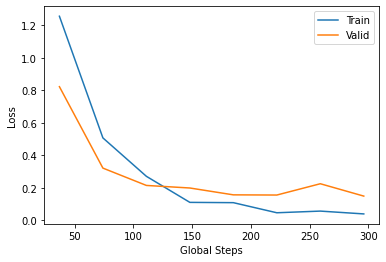

In [38]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(PATH + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [39]:
def evaluate(model, test_set=test_iter):
  y_pred = []
  y_true = []
  model.eval()
  with torch.no_grad():
    for (labels, titlebody), _ in tqdm(test_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        output = model(titlebody, labels)
        _, output = output
        y_pred.extend(torch.argmax(output, 1).tolist())
        y_true.extend(labels.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[0,1,2,3,4], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix')

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')

  ax.xaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])
  ax.yaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/10 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           0     0.9189    1.0000    0.9577        34
           1     1.0000    1.0000    1.0000        28
           2     1.0000    0.9286    0.9630        28
           3     1.0000    0.9714    0.9855        35
           4     0.9630    0.9630    0.9630        27

    accuracy                         0.9737       152
   macro avg     0.9764    0.9726    0.9738       152
weighted avg     0.9753    0.9737    0.9738       152



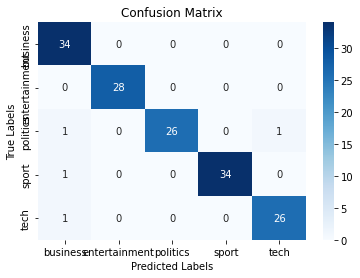

In [40]:
bert_model = BertModel().to(device)
load_model(PATH + '/model.pt', bert_model)
evaluate(bert_model, test_iter)